In [1]:
import numpy as np
import pandas as pd
from lxml import etree
import cv2
import matplotlib.pyplot as plt

In [2]:
image_folder = "/Users/lydia/desktop/dataset_cvat/images/frames/"

In [3]:
tree = etree.parse("/Users/lydia/desktop/dataset_cvat/annotations.xml")
# for user in tree.xpath("/users/user/nom"):
#     print(user.text)

In [4]:
# get image anotation from cvat xml file

def get_image_annotation(tree):
    image_annotation = []
    for image in tree.xpath("/annotations/image"):
        image_id = image.get("id")
        image_name = image.get("name")
        image_width = image.get("width")
        image_height = image.get("height")
        pts = []
        for point in image.xpath("points"):
            pos = point.get("points")
            label = point.get("label")
            pts.append({
                "px": float(pos.split(",")[0]),
                "py": float(pos.split(",")[1]), 
                "label": label
                })
        
        image_annotation.append({
            "image_id": image_id,
            "image_name": image_name,
            "image_width": image_width,
            "image_height": image_height,
            "points": pts
        })
    return image_annotation

In [5]:
annot = get_image_annotation(tree)


In [6]:
annot[:3]

[{'image_id': '0',
  'image_name': 'images/frames/1002.jpg',
  'image_width': '1920',
  'image_height': '1080',
  'points': [{'px': 1518.2, 'py': 412.8, 'label': '3'},
   {'px': 1703.9, 'py': 443.0, 'label': '24'},
   {'px': 1362.4, 'py': 460.4, 'label': '23'},
   {'px': 1918.5, 'py': 479.5, 'label': '22'},
   {'px': 1798.0, 'py': 488.1, 'label': '21'},
   {'px': 1556.0, 'py': 507.1, 'label': '25'},
   {'px': 1907.0, 'py': 596.5, 'label': '26'},
   {'px': 396.9, 'py': 455.5, 'label': '2'},
   {'px': 401.95, 'py': 560.21, 'label': '15'},
   {'px': 410.59, 'py': 734.45, 'label': '16'}]},
 {'image_id': '1',
  'image_name': 'images/frames/1008.jpg',
  'image_width': '1920',
  'image_height': '1080',
  'points': [{'px': 1515.2, 'py': 410.2, 'label': '3'},
   {'px': 1699.4, 'py': 441.4, 'label': '24'},
   {'px': 1357.65, 'py': 460.85, 'label': '23'},
   {'px': 1917.8, 'py': 480.8, 'label': '22'},
   {'px': 1798.4, 'py': 487.9, 'label': '21'},
   {'px': 1551.1, 'py': 506.9, 'label': '25'},
  

In [7]:
def plot_image_annotation(annot, image):
    for image in annot:
        print(image["image_name"])
        print(image["points"])
        print("------------------------------------------------")
        
        cv2.putPoints(image, image["points"], (0, 255, 0))

In [8]:
from enum import Enum
from box import Box
import cv2

# refer to https://www.playfinder.com/blog/football-pitch-size

class SoccerFieldType(Enum):
    FIVE_A_SIDE = "5v5"
    FIVE_A_SIDE_RECT = "5v5r"
    SEVEN_A_SIDE = "7v7"
    ELEVEN_A_SIDE = "11v11"

# Size in mettrer
class SoccerFieldSize(Enum):
    FIVE_A_SIDE = {
        "w": 36.5, "h": 27.5, "center_circle": 2.74, "penalty_area": {"radius": 6}, "penalty_shot": 6
    }
    FIVE_A_SIDE_RECT = {
        "w": 30.5, "h": 21, "center_circle": 2.74, "penalty_shot": 6, "goal_area": {"w": 3, "h": 6}
    }
    SEVEN_A_SIDE = {
        "w": 55, "h": 36.5, "center_circle": 5.49, "penalty_area": {"w": 9, "h": 16.5}, "penalty_shot": 8
    }
    ELEVEN_A_SIDE = {
        "w": 110, "h": 80, "center_circle": 9.14, "penalty_area": {"w": 16.5, "h": 40.3}, 
        "penalty_shot": 10.97, "goal_area": {"w": 5.49, "h": 11.89}
    }

class SoccerFieldFactory:

    def __init__(self, field_type: SoccerFieldType = SoccerFieldType.ELEVEN_A_SIDE, field_size = {}, scale=None) -> None:
        self.field_type = field_type
        if isinstance(scale, type(None)):
            self.scale = self.__default_scale()
        else:
            self.scale = scale
        self.thic = 3
        self.pad = 20
        self.line_color = (255,255,255)
        self.field_color = (108,187,60)

        if field_size == {}:
            self.field_size = SoccerFieldSize[field_type.name].value
        else:
            self.field_size = field_size

        self.field_size = Box(self.field_size)
        self.field_size = self.scale_field(self.field_size, self.scale)

    def __default_scale(self):
        scale = 10
        
        if self.field_type == SoccerFieldType.FIVE_A_SIDE:
            scale = 75
        elif self.field_type == SoccerFieldType.FIVE_A_SIDE_RECT:
            scale = 75
        elif self.field_type == SoccerFieldType.SEVEN_A_SIDE:  
            scale = 30
        elif self.field_type == SoccerFieldType.ELEVEN_A_SIDE:  
            scale = 10
        else:
            print("Field type not recognized")

        return scale

    def scale_field(self, field_size, s):
        s_field_size = {}
        for key, value in field_size.items():
            if isinstance(value, type(Box({}))) or isinstance(value, type(dict)):
                s_field_size[key] = self.scale_field(value, s)
            else:
                s_field_size[key] = field_size[key]*s
        return Box(s_field_size)
 
    """ 5V5r """
    def __intern_keypoint_5v5r(self):
        field_size = self.field_size

        pad = self.pad
        w = int(field_size.w)
        h = int(field_size.h)

        goal_start_h = int((h/2) + (field_size.goal_area.h/2))
        goal_end_h = int((h/2) - (field_size.goal_area.h/2))

        key_point = []

        key_point.append([pad, pad]) #p1
        key_point.append([w - pad, pad]) #p2

        key_point.append([pad, goal_end_h]) #p3
        key_point.append([field_size.goal_area.w+pad, goal_end_h]) #p4
        key_point.append([pad, goal_start_h]) #p5
        key_point.append([field_size.goal_area.w+pad, goal_start_h]) #p6

        key_point.append([pad, h - pad]) #p7
        key_point.append([w-pad, h - pad]) #p8

        key_point.append([w-field_size.goal_area.w-pad, goal_start_h]) #p9
        key_point.append([w-pad, goal_start_h]) #p10
        key_point.append([w-field_size.goal_area.w-pad, goal_end_h]) #p11
        key_point.append([w-pad, goal_end_h]) #p12

        return key_point

    def __intern_surface_5v5r(self):
        field_size = self.field_size

        pad = self.pad
        w = int(field_size.w)
        h = int(field_size.h)

        goal_start_h = int((h/2) + (field_size.goal_area.h/2))
        goal_end_h = int((h/2) - (field_size.goal_area.h/2))

        key_point = []
        key_point.append([pad, goal_end_h]) #p3
        key_point.append([field_size.goal_area.w+pad, goal_end_h]) #p4
        key_point.append([pad, goal_start_h]) #p5
        key_point.append([field_size.goal_area.w+pad, goal_start_h]) #p6

    
        key_point.append([w-field_size.goal_area.w-pad, goal_end_h]) #p11
        key_point.append([w-pad, goal_end_h]) #p12
        key_point.append([w-field_size.goal_area.w-pad, goal_start_h]) #p9
        key_point.append([w-pad, goal_start_h]) #p10

        return key_point

    def __intern_field_5v5r(self):
        field_size = self.field_size
        t = self.thic

        pad = self.pad
        c = self.line_color
        w = int(field_size.w)
        h = int(field_size.h)

        cf = (int(w/2), int(h/2))
        goal_start_h = int((h/2) + (field_size.goal_area.h/2))
        goal_end_h = int((h/2) - (field_size.goal_area.h/2))

        #Create figure
        base = np.zeros((h,w,3), dtype=np.uint8)
        base[:] = self.field_color

        base = cv2.line(base, (pad, pad), ((w)-pad, pad), c, t) 
        base = cv2.line(base, (pad, pad), (pad, (h) - pad), c, t) 
        base = cv2.line(base, (pad, (h)-pad), ((w)-pad, (h) - pad), c, t) 
        base = cv2.line(base, ((w)-pad, pad), ((w)-pad, (h) - pad), c, t) 

        base = cv2.circle(base, cf, int(field_size.center_circle), c, t)
        base = cv2.circle(base, cf, int(5), c, t)

        base = cv2.line(base, (pad, goal_end_h), (field_size.goal_area.w+pad, goal_end_h), c, t) 
        base = cv2.line(base, (field_size.goal_area.w+pad, goal_end_h), (field_size.goal_area.w+pad, goal_start_h), c, t) 
        base = cv2.line(base, (pad, goal_start_h), (field_size.goal_area.w+pad, goal_start_h), c, t) 

        base = cv2.line(base, (w-field_size.goal_area.w-pad, goal_end_h), (w-pad, goal_end_h), c, t)
        base = cv2.line(base, (w-field_size.goal_area.w-pad, goal_end_h), (w-field_size.goal_area.w-pad, goal_start_h), c, t)
        base = cv2.line(base, (w-field_size.goal_area.w-pad, goal_start_h), (w-pad, goal_start_h), c, t) 
    
        return base

    """ 11V11 """
    def __intern_keypoint_11v11(self):
        field_size = self.field_size

        pad = self.pad
        w = int(field_size.w)
        h = int(field_size.h)

        goal_start_h = int((h/2) + (field_size.goal_area.h/2))
        goal_end_h = int((h/2) - (field_size.goal_area.h/2))

        penalty_start_h = int((h/2) + (field_size.penalty_area.h/2))
        penalty_end_h = int((h/2) - (field_size.penalty_area.h/2))

        key_point = []

        key_point.append([pad, pad]) #p1
        key_point.append([int(w/2), pad]) #p2
        key_point.append([w - pad, pad]) #p3

        key_point.append([pad, penalty_end_h]) #p4
        key_point.append([field_size.penalty_area.w+pad, penalty_end_h]) #p5

        key_point.append([pad, goal_end_h]) #p6
        key_point.append([field_size.goal_area.w+pad, goal_end_h]) #p7
        key_point.append([pad, goal_start_h]) #p8
        key_point.append([field_size.goal_area.w+pad, goal_start_h]) #p9

        key_point.append([pad, penalty_start_h]) #p10
        key_point.append([field_size.penalty_area.w+pad, penalty_start_h]) #p11

        key_point.append([pad, h - pad]) #p12
        key_point.append([int(w/2), h - pad]) #p13
        key_point.append([w-pad, h - pad]) #p14

        key_point.append([int(w/2), int(h/2) - int(field_size.center_circle)]) #p15
        key_point.append([int(w/2), int(h/2) + int(field_size.center_circle)]) #p16

        key_point.append([w-pad, penalty_start_h]) #p17
        key_point.append([w-field_size.penalty_area.w-pad, penalty_start_h]) #p18

        key_point.append([w-field_size.goal_area.w-pad, goal_start_h]) #p19
        key_point.append([w-pad, goal_start_h]) #p20
        key_point.append([w-field_size.goal_area.w-pad, goal_end_h]) #p21
        key_point.append([w-pad, goal_end_h]) #p22

        key_point.append([w-field_size.penalty_area.w-pad, penalty_end_h]) #p23
        key_point.append([w-pad, penalty_end_h]) #p24

        return np.array(key_point).astype(int).tolist()

    def __intern_surface_11v11(self):
        field_size = self.field_size

        pad = self.pad
        w = int(field_size.w)
        h = int(field_size.h)

        penalty_start_h = int((h/2) + (field_size.penalty_area.h/2))
        penalty_end_h = int((h/2) - (field_size.penalty_area.h/2))

        key_point = []

        key_point.append([pad, penalty_end_h]) #p4
        key_point.append([field_size.penalty_area.w+pad, penalty_end_h]) #p5
        key_point.append([pad, penalty_start_h]) #p10
        key_point.append([field_size.penalty_area.w+pad, penalty_start_h]) #p11

        key_point.append([w-field_size.penalty_area.w-pad, penalty_end_h]) #p23
        key_point.append([w-pad, penalty_end_h]) #p24
        key_point.append([w-pad, penalty_start_h]) #p17
        key_point.append([w-field_size.penalty_area.w-pad, penalty_start_h]) #p18

        return key_point
    
    def __intern_field_11v11(self):
        kp =  self.__intern_keypoint_11v11()
        field_size = self.field_size
        t = self.thic

        c = self.line_color
        w = int(field_size.w)
        h = int(field_size.h)
        cf = (int(w/2), int(h/2))
        base = np.zeros((h,w,3), dtype=np.uint8)
        base[:] = self.field_color

        base = cv2.line(base, kp[0], kp[2], c, t)
        base = cv2.line(base, kp[0], kp[11], c, t)
        base = cv2.line(base, kp[11], kp[13], c, t)
        base = cv2.line(base, kp[13], kp[2], c, t)

        base = cv2.line(base, kp[3], kp[4], c, t)
        base = cv2.line(base, kp[4], kp[10], c, t)
        base = cv2.line(base, kp[9], kp[10], c, t)
        base = cv2.line(base, kp[5], kp[6], c, t)
        base = cv2.line(base, kp[6], kp[8], c, t)
        base = cv2.line(base, kp[7], kp[8], c, t)

        base = cv2.circle(base, cf, int(field_size.center_circle), c, t)
        base = cv2.circle(base, cf, int(5), c, -1)

        base = cv2.line(base, kp[22], kp[23], c, t)
        base = cv2.line(base, kp[22], kp[17], c, t)
        base = cv2.line(base, kp[17], kp[16], c, t)
        base = cv2.line(base, kp[20], kp[21], c, t)
        base = cv2.line(base, kp[20], kp[18], c, t)
        base = cv2.line(base, kp[18], kp[19], c, t)

        return base


    def draw_pitch(self):
        pitch = None
        
        if self.field_type == SoccerFieldType.FIVE_A_SIDE:
            pass
        elif self.field_type == SoccerFieldType.FIVE_A_SIDE_RECT:
            pitch = self.__intern_field_5v5r()
        elif self.field_type == SoccerFieldType.SEVEN_A_SIDE:  
            pass
        elif self.field_type == SoccerFieldType.ELEVEN_A_SIDE:  
            pitch = self.__intern_field_11v11()
        else:
            print("Field type not recognized")

        return pitch

    def extract_keypoint(self):
        key_point = None
        if self.field_type == SoccerFieldType.FIVE_A_SIDE:
            pass
        elif self.field_type == SoccerFieldType.FIVE_A_SIDE_RECT:
            key_point = self.__intern_keypoint_5v5r()
        elif self.field_type == SoccerFieldType.SEVEN_A_SIDE:  
            pass
        elif self.field_type == SoccerFieldType.ELEVEN_A_SIDE:  
            key_point = self.__intern_keypoint_11v11()
        else:
            print("Field type not recognized")

        return key_point

    def surface_keypoints(self):
        key_point = None
        if self.field_type == SoccerFieldType.FIVE_A_SIDE:
            pass
        elif self.field_type == SoccerFieldType.FIVE_A_SIDE_RECT:
            key_point = self.__intern_surface_5v5r()
        elif self.field_type == SoccerFieldType.SEVEN_A_SIDE:  
            pass
        elif self.field_type == SoccerFieldType.ELEVEN_A_SIDE:  
            key_point = self.__intern_surface_11v11()
        else:
            print("Field type not recognized")
            
        return key_point


In [9]:
#ompute homography matrix
pts_2D = SoccerFieldFactory().extract_keypoint()

In [10]:
def plot_pitch(num_frames):
    field = SoccerFieldFactory().draw_pitch()
    a = annot[num_frames]
    image = cv2.imread(image_folder + a["image_name"].split("/")[-1])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for point in a["points"]:
        cv2.circle(image, (int(point["px"]), int(point["py"])), 5, (255, 0, 255), -1)
        print(point["label"])
        pt2D = pts_2D[int(point["label"]) - 1] if (int(point["label"]) - 1) < len(pts_2D) else None
        if pt2D is not None:
            cv2.circle(field, (pt2D[0], pt2D[1]), 5, (255, 0, 255), -1)
    

    plt.figure(figsize=(13,8))
    plt.imshow(image)
    plt.show()
    plt.figure(figsize=(15, 7))
    plt.imshow(field)


0: 384x640 18 persons, 437.9ms
Speed: 4.9ms preprocess, 437.9ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
[(205, 718, 256, 832, 0.8714457154273987, 0), (688, 701, 729, 809, 0.8061866760253906, 0), (979, 634, 1019, 730, 0.804506778717041, 0), (1240, 534, 1269, 609, 0.7358224391937256, 0), (593, 496, 620, 558, 0.7300583720207214, 0), (749, 496, 774, 559, 0.7211887240409851, 0), (1067, 520, 1103, 589, 0.7087771892547607, 0), (1276, 542, 1301, 611, 0.7049597501754761, 0), (937, 495, 963, 555, 0.6249889135360718, 0), (979, 492, 1013, 552, 0.6041950583457947, 0), (1029, 478, 1053, 532, 0.5711212754249573, 0), (686, 486, 708, 542, 0.526058554649353, 0), (429, 453, 451, 513, 0.5008377432823181, 0), (325, 446, 353, 498, 0.4986669421195984, 0), (851, 488, 883, 555, 0.4848608076572418, 0), (699, 443, 715, 489, 0.3681130111217499, 0), (897, 458, 920, 515, 0.31621837615966797, 0), (843, 476, 869, 534, 0.31031161546707153, 0)]


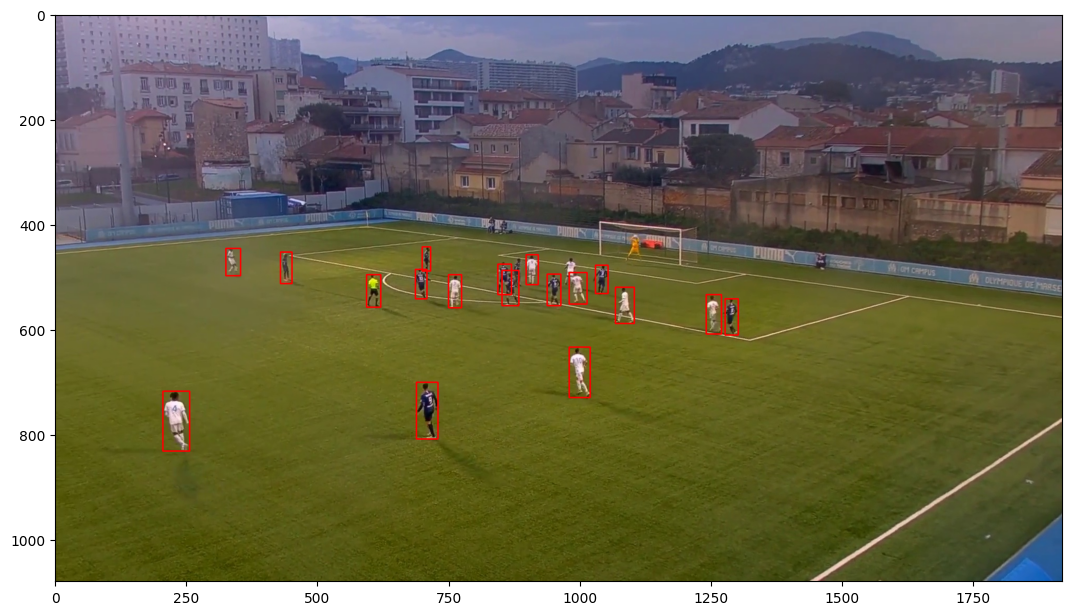

In [19]:
from ultralytics import YOLO

model = YOLO("/Users/lydia/desktop/yolov8m.pt")

def detect_persons(num_frames):
    a = annot[num_frames]
    image = cv2.imread(image_folder + a["image_name"].split("/")[-1])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = model(image)

    for result in results:
        detections = [] 
        for r in result.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = r
            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)
            class_id = int(class_id)
            if class_id == 0: # only detect players
                detections.append((x1, y1, x2, y2, score, class_id))

    print(detections)

    # plot the image with the bounding boxes
    for detection in detections:
        x1, y1, x2, y2, score, class_id = detection
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    plt.figure(figsize=(13,8))
    plt.imshow(image)
    plt.savefig("./plot/player_detection.jpg")

detect_persons(100)


27
1
5
4
6
7
8
9
28
11


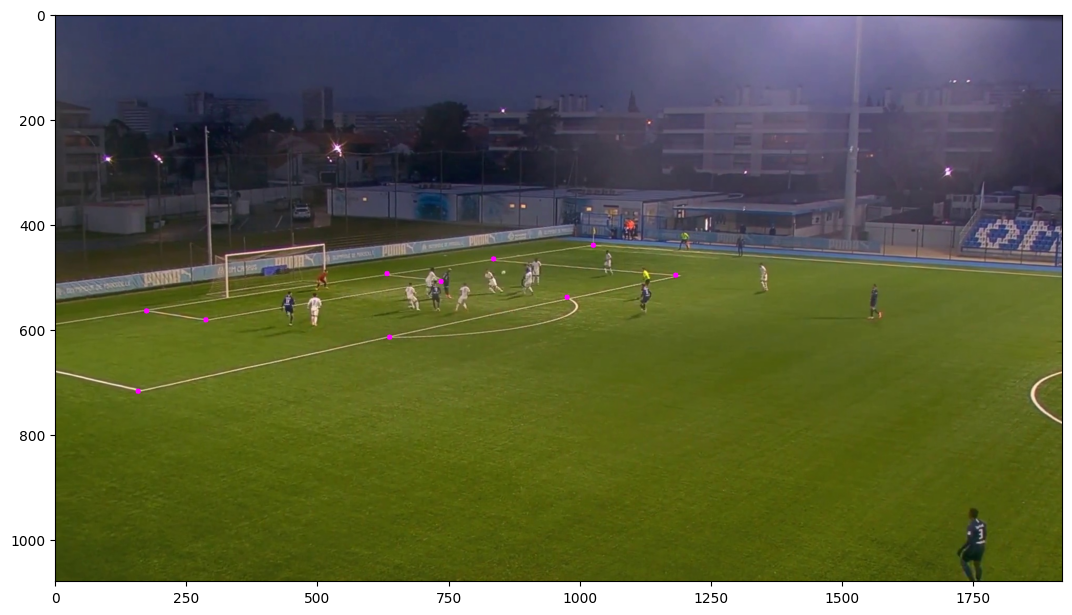

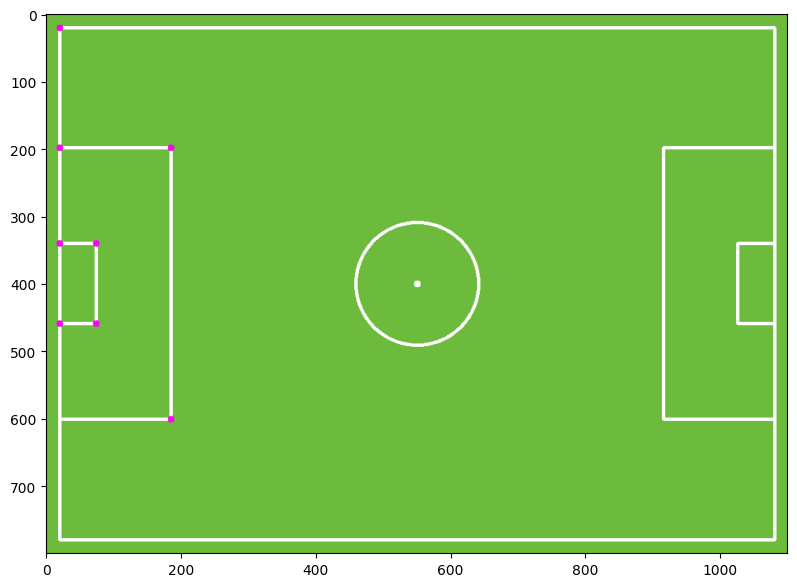

In [ ]:
plot_pitch(300)